In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from prettytable import PrettyTable

In [2]:
rootPath = './spectrograms/Songs/'
imgPath = 'test/'
testImgPath = rootPath + imgPath + os.listdir(rootPath + imgPath)[0]
res = [cv2.imread(testImgPath).shape[0], cv2.imread(testImgPath).shape[1]]

print('Current Resolution: \t' + str(res))

#res = [int(res[0]/2), int(res[1]/2)]
#print('New Resolution: \t' + str(res))

#res = [int(res[0]/1.5), int(res[1]/1.5)]
#print('New Resolution: \t' + str(res))

res = [int(res[0]/4), int(res[1]/4)]
print('New Resolution: \t' + str(res))

Current Resolution: 	[576, 1080]
New Resolution: 	[144, 270]


In [3]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

In [4]:
train_dataset = train.flow_from_directory(
    rootPath + 'train/',
    target_size = (res[0], res[1]),
    batch_size = 3,
    class_mode = 'binary'
)

validation_dataset = validation.flow_from_directory(
    rootPath + 'validate/',
    target_size = (res[0], res[1]),
    batch_size = 3,
    class_mode = 'binary'
)

Found 87 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [5]:
#print(train_dataset.class_indices)
#print(validation_dataset.class_indices)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3), activation='relu', input_shape=(res[0], res[1], 3)),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    #
    #tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    #tf.keras.layers.MaxPool2D(2,2),
    ##
    tf.keras.layers.Flatten(),
    ##
    tf.keras.layers.Dense(256, activation='relu'),
    ##
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.001),
    metrics=['accuracy']
)

In [8]:
model_fit = model.fit(
    train_dataset,
    steps_per_epoch=15,
    epochs=100,
    validation_data=validation_dataset
)

Epoch 1/100
15/15 [==============================] - 5s 281ms/step - loss: 53.9881 - accuracy: 0.2653 - val_loss: -30.9518 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - 3s 187ms/step - loss: -36.3172 - accuracy: 0.2353 - val_loss: -111.5870 - val_accuracy: 0.3333
Epoch 3/100
15/15 [==============================] - 3s 188ms/step - loss: -64.5063 - accuracy: 0.5368 - val_loss: -108.6648 - val_accuracy: 0.6250
Epoch 4/100
15/15 [==============================] - 3s 204ms/step - loss: -1219.5698 - accuracy: 0.4078 - val_loss: -1993.2311 - val_accuracy: 0.3333
Epoch 5/100
15/15 [==============================] - 3s 208ms/step - loss: -5828.2004 - accuracy: 0.2947 - val_loss: -6362.0786 - val_accuracy: 0.3333
Epoch 6/100
15/15 [==============================] - 3s 191ms/step - loss: -14234.5166 - accuracy: 0.2596 - val_loss: -15117.3359 - val_accuracy: 0.3333
Epoch 7/100
15/15 [==============================] - 3s 174ms/step - loss: 2101.8460 - accuracy: 0.3522

In [9]:
def resultStore(file, pred, results):
    pred = pred.lower()
    if 'or' in pred:
        preds = pred.split('or')
        if preds[0].strip() in file or preds[1].strip() in file:
            results[0] = 'PASS'
            results[1] = results[1] + 1
        else:
            results[0] = 'FAIL'
            results[2] = results[2] + 1
        return results
    else:
        if pred in file:
            results[0] = 'PASS'
            results[1] = results[1] + 1
        else:
            results[0] = 'FAIL'
            results[2] = results[2] + 1
        return results

def resultStats(results):
    total = results[1] + results[2]
    p = round(results[1]*100/total, 2)
    f = round(results[2]*100/total, 2)
    return 'Pass: ' + str(p) + '% (' + str(results[1]) + '), Fail: ' + str(f) + '% (' + str(results[2]) + '), Total: ' + str(total)

In [10]:
validation_dataset.class_indices
classes = {v: k for k, v in validation_dataset.class_indices.items()}
print(classes)

{0: '1. Clean-2.5-5-5-5-5-5-5-INT', 1: '2. Rhythm-2.5-5-5-5-5-5-5-INT', 2: '3. Lead-2.5-5-5-5-5-5-5-INT'}


In [11]:
testPath = rootPath + 'test/'
results = ["", 0, 0]

table = PrettyTable()
table.field_names = ["1", "File", "2", "Class", "3", "Prediction", "4", "Result", " "]

for i in os.listdir(testPath):
    img = image.load_img(
        testPath + '//' + i,
        target_size = (res[0], res[1])
    )

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    prediction = int(model.predict(images))
    
    results = resultStore(i, classes[prediction], results)
    splt = i.split('_session_')
    clss = splt[0]
    fname = splt[1].replace('_', ' ')
    table.add_row(["", fname[:-4], "", clss, "", classes[prediction], "", results[0], ""])

table.align = 'l'
print(table)

print('\n' + resultStats(results))

+---+-----------------------------+---+------------------------+---+-------------------------------+---+--------+---+
| 1 | File                        | 2 | Class                  | 3 | Prediction                    | 4 | Result |   |
+---+-----------------------------+---+------------------------+---+-------------------------------+---+--------+---+
|   | Soundcloud 10               |   | clean-2.5-5-5-5-5-5-5  |   | 2. Rhythm-2.5-5-5-5-5-5-5-INT |   | FAIL   |   |
|   | The Call Of Ktulu           |   | clean-2.5-5-5-5-5-5-5  |   | 2. Rhythm-2.5-5-5-5-5-5-5-INT |   | FAIL   |   |
|   | The Number Of The Beast     |   | clean-2.5-5-5-5-5-5-5  |   | 2. Rhythm-2.5-5-5-5-5-5-5-INT |   | FAIL   |   |
|   | The Pale King               |   | clean-2.5-5-5-5-5-5-5  |   | 2. Rhythm-2.5-5-5-5-5-5-5-INT |   | FAIL   |   |
|   | You Shook Me All Night Long |   | clean-2.5-5-5-5-5-5-5  |   | 2. Rhythm-2.5-5-5-5-5-5-5-INT |   | FAIL   |   |
|   | Soundcloud 10               |   | lead-2.5-5-5-5-5

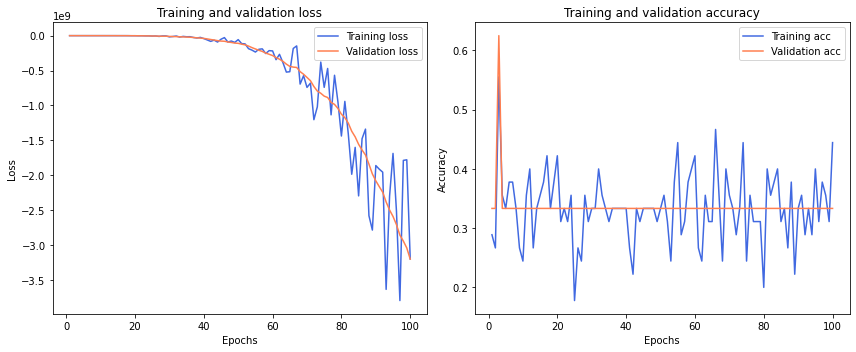

In [13]:
#plot the training and validation accuracy and loss at each epoch
plt.subplot(1, 2, 1)
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'royalblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, 'royalblue', label='Training acc')
plt.plot(epochs, val_acc, 'coral', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.rcParams['figure.figsize'] = [12, 5]
plt.tight_layout()
plt.savefig("test.pdf", format="pdf")
plt.show()